# **Structured Noise2Void**

## Requirements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Google Colab needs to be configured to run on GPU**
1. Edit -> Notebook settings -> Hardware Accelerator -> Select GPU

**The directory needs to be in your drive**
1. Go to your Shared Drive and right click "Columbia_Umed"
2. Click "Add shortcut to Drive"

## Libraries

In [2]:
!pip install csbdeep==0.5.0 keras==2.2.4 n2v 

     |████████████████████████████████| 71kB 1.9MB/s 
     |████████████████████████████████| 317kB 7.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 112kB 13.3MB/s 
     |████████████████████████████████| 17.9MB 1.5MB/s 
     |████████████████████████████████| 552kB 34.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [14]:
# We import all our dependencies.
%tensorflow_version 1.x
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
from csbdeep.io import save_tiff_imagej_compatible
import urllib
import os
import zipfile
from tifffile import imread

## Image Selection


In [2]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()



1.   Locate a folder with images in your Google Drive and copy its path
2.   Paste the path between quotation marks in:
  * imgs = datagen.load_imgs_from_directory(directory = " ")

In [22]:
# We load all the '.tif' files from the 'data' directory.
# If you want to load other types of files see the RGB example.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "/content/drive/My Drive/Columbia_Umed/test_images_for_struct/",  dims="TYX")

# Let's look at the shape of the images.
print(imgs[0].shape) # THIS IS MY IMAGE
print(imgs[1].shape) # THIS IS "flower.tif" from the example
# The function automatically added two extra dimensions to the images:
# One at the beginning, is used to hold a potential stack of images such as a movie.
# One at the end, represents channels.

(4, 2048, 2048, 1)
(100, 1024, 1024, 1)


In [4]:
# Shuffles the images in the list to prevent order-biased training
import random
random.shuffle(imgs)

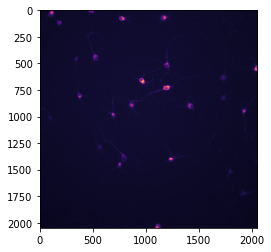

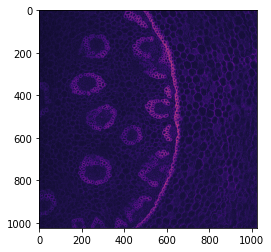

In [23]:
# Lets' look at the images.
# We have to remove the added extra dimensions to display them as 2D images.
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.show()

plt.imshow(imgs[1][0,...,0], cmap='magma')
plt.show()

## Data Preparation

In [24]:
# split up image into little non-overlapping patches for training.
# y<832 (top of image) is training, y>=832 (bottom of image) is validation

patch_shape = (96,96)

imgs_train = [imgs[0][:,:832]]
X = datagen.generate_patches_from_list(imgs_train, shape=patch_shape)

imgs_vali = [imgs[0][:,832:]]
X_val = datagen.generate_patches_from_list(imgs_vali, shape=patch_shape)

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)

Generated patches: (1344, 96, 96, 1)
Generated patches: (1344, 96, 96, 1)
Generated patches: (1344, 96, 96, 1)
Generated patches: (1344, 96, 96, 1)
Generated patches: (2016, 96, 96, 1)
Generated patches: (2016, 96, 96, 1)
Generated patches: (2016, 96, 96, 1)
Generated patches: (2016, 96, 96, 1)


In [ ]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

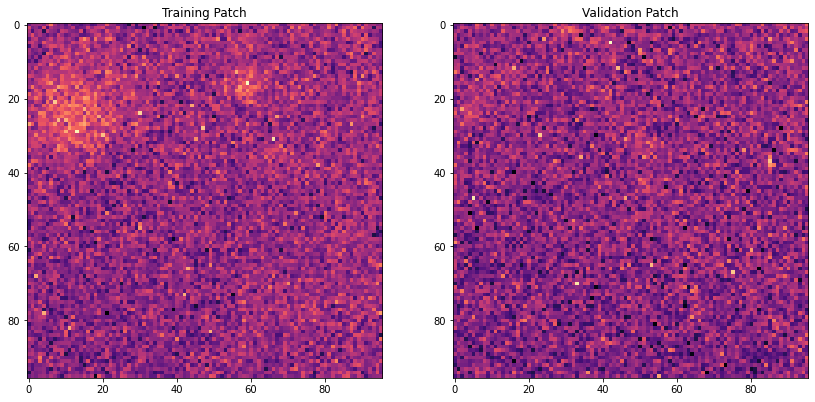

In [25]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

## **Configure**

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.

When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.

Other pixel manipulators:

normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
identity: performs no pixel manipulation
For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

to make this example notebook execute faster, we have set train_epochs to only 10.
For better results we suggest 100 to 200 train_epochs.

In [26]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=5, train_loss='mse', batch_norm=True, 
                   train_batch_size=32, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, structN2Vmask = [[0,1,1,1,1,1,1,1,1,1,0]])

# Let's look at the parameters stored in the config-object.
vars(config)

{'axes': 'YXC',
 'batch_norm': True,
 'means': ['1214.8772'],
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2v_patch_shape': (64, 64),
 'n2v_perc_pix': 0.198,
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'single_net_per_channel': True,
 'stds': ['200.37334'],
 'structN2Vmask': [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]],
 'train_batch_size': 32,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 5,
 'train_learning_rate': 0.0004,
 'train_loss': 'mse',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 42,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': False}



1.   Change the name of the model in:
  * model_name = ' '
2.   Make sure the output directory path is correct in:
  * basedir = ' '



In [27]:
# a name used to identify the model
model_name = 'struct_test'
# the base directory in which our model will live
basedir = '/content/drive/My Drive/Columbia_Umed/n2v/models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

/usr/local/lib/python3.6/dist-packages/n2v/models/n2v_standard.py:428: UserWarning: output path for model already exists, files may be overwritten: /content/drive/My Drive/Columbia_Umed/n2v/models/struct_test
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training

In [28]:
# We are ready to start training now.
history = model.train(X, X_val)

StructN2V Mask is:  [[0 1 1 1 1 1 1 1 1 1 0]]
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 8064/8064 [00:08<00:00, 974.20it/s] 


Epoch 1/5
42/42 [==============================] - 7s 167ms/step - loss: 0.5244 - n2v_mse: 0.5244 - n2v_abs: 0.4459 - val_loss: 0.7845 - val_n2v_mse: 0.7845 - val_n2v_abs: 0.4715


AttributeError: ignored

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [ ]:
model.export_TF(name='Noise2Void - NeuO', 
                description='N2V for NeuO Images', 
                authors=["Tim-Oliver Buchholz", "Alexander Krull", "Florian Jug"],
                test_img=X_val[0,...,0], axes='YX',
                patch_shape=patch_shape)

In [ ]:
!kill -9 -1

# **Prediction**

## Model Selection

1. Locate the trained model folder and past its path in:
  * model_path = ' '

In [ ]:
model_path = '/content/drive/My Drive/Columbia_Umed/n2v/models/struct_n2v_022_DIV12_post_fiji_post_cp_3'
model_name = model_path.split('/')[-1]
model_path = model_path.split('/')[:-1]
s = '/'
model_path = s.join(model_path)
print(model_path)
print(model_name)

/content/drive/My Drive/Columbia_Umed/n2v/models
struct_n2v_022_DIV12_post_fiji_post_cp_3


In [ ]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
#model_name = 'n2v_64_300_background_subtraction'
#basedir = 'models'

model = N2V(config=None, name=model_name, basedir=model_path)

Loading network weights from 'weights_best.h5'.


## Predict

1. Locate the folder with images and past its path in:
  * data_path = ' '

In [ ]:
data_path = '/content/drive/My Drive/Columbia_Umed/input/022_DIV12_post_fiji_post_cp_3'
folder_name = data_path.split('/')[-1]

In [ ]:
output_path = '/content/drive/My Drive/Columbia_Umed/output/MODEL_' + model_name + '_IMAGE_' + folder_name
if not os.path.exists(output_path):
  os.mkdir(output_path)
  print('Output directory created as:\n' + output_path)
else:
  print('Output directory already exists:\n' + output_path)

Output directory created as:
/content/drive/My Drive/Columbia_Umed/output/MODEL_struct_n2v_022_DIV12_post_fiji_post_cp_3_IMAGE_022_DIV12_post_fiji_post_cp_3


In [ ]:
for path, dirs, files in os.walk(data_path, topdown=True):

  for filename in files:
    fn = filename.split('.')[0]
    print(fn)
    image_path = path + '/' + filename
    #print(image_path)
    # We load the data we want to process.
    input_train = imread(image_path)

    # Here we process the data.
    # The parameter 'n_tiles' can be used if images are to big for the GPU memory.
    # If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
    # This can take longer.
    pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

    # We load and process the data we previously used for validation.
    input_val = imread(image_path)
    pred_val = model.predict(input_val, axes='YX')


    # Save the output images
    save_tiff_imagej_compatible(output_path + '/' + fn + '_pred_train.tif', pred_train, axes='YX')
    save_tiff_imagej_compatible(output_path + '/' + fn + '_pred_validation.tif', pred_val, axes='YX')

C3-C1_100k_20x_1_corrected


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


C3-C1_100k_20x_2_corrected


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


C3-C1_100k_20x_3_corrected


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


C3-C1_100k_20x_4_corrected


100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


C3-C2_50k_20x_1_corrected


100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


C3-C2_50k_20x_2_corrected


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


C3-C2_50k_20x_3_corrected


100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


C3-C2_50k_20x_4_corrected


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


C3-C3_100k_20x_1_corrected


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


C3-C3_100k_20x_2_corrected


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


C3-C3_100k_20x_3_corrected


100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


C3-C3_100k_20x_4_corrected


100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


C3-C4_50k_20x_1_corrected


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


C3-C4_50k_20x_2_corrected


100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


C3-C4_50k_20x_3_corrected


100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


C3-C4_50k_20x_4_corrected


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


C3-C5_100k_20x_1_corrected


100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


C3-C5_100k_20x_2_corrected


100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


C3-C5_100k_20x_3_corrected


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


C3-C5_100k_20x_4_corrected


100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


C3-C6_50k_20x_1_corrected


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


C3-C6_50k_20x_2_corrected


100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


C3-C6_50k_20x_3_corrected


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


C3-C6_50k_20x_4_corrected


100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


In [ ]:
# # Let's look at the results.
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.imshow(input_train[:1500:,:1500],cmap="magma")
# plt.title('Input');
# plt.subplot(1,2,2)
# plt.imshow(pred_train[:1500,:1500],cmap="magma")
# plt.title('Prediction');

In [ ]:
# # Let's look at the results.
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plt.imshow(input_val,cmap="magma")
# plt.title('Input');
# plt.subplot(1,2,2)
# plt.imshow(pred_val,cmap="magma")
# plt.title('Prediction');